In [1]:
!pip install monai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 990 kB 5.2 MB/s 


In [2]:
from glob import glob
import shutil
import os
import nibabel as nib
import numpy as np
from tqdm import tqdm

from monai.transforms import(
    Compose,
    AddChanneld,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    Activations,
    ScaleIntensity,
    RandRotate,
    RandFlip,
    RandZoom,
    RandGaussianNoise,
    Resize,
)
from monai.utils import first
from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import set_determinism
from matplotlib import pyplot as plt
from monai.losses import DiceLoss, DiceCELoss
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.data import CacheDataset, DataLoader, Dataset
from monai.inferers import sliding_window_inference

import torch

In [3]:
'''
preprocessing functions below doing preprocessing of data which is nifti format

-> we are using Monai transforms to transforme our data.
-> We are using basic transforms after using various diffrent tranforms the below sequence is giving the good result.
'''



def pre_process_data(in_dir, pixdim=(1.5, 1.5, 1.0), a_min=-200, a_max=200, spatial_size=[128,128,64]):


    set_determinism(seed=0)

    train_vol_path = sorted(glob(os.path.join(in_dir, "TrainVolumes", "*.nii.gz")))
    train_seg_path = sorted(glob(os.path.join(in_dir, "TrainSegmentation", "*.nii.gz")))

    test_vol_path = sorted(glob(os.path.join(in_dir, "TestVolumes", "*.nii.gz")))
    test_seg_path = sorted(glob(os.path.join(in_dir, "TestSegmentation", "*.nii.gz")))

    train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(train_vol_path, train_seg_path)]
    test_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(test_vol_path, test_seg_path)]
    
    # print(test_files);

    train_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            AddChanneld(keys=["vol", "seg"]),
            # ScaleIntensity(),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            # RandFlip(spatial_axis=0, prob=0.5),
            # RandRotate(prob=0.3),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True), 
            CropForegroundd(keys=["vol", "seg"], source_key="vol"),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),   
            ToTensord(keys=["vol", "seg"]),
            # RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
            # RandGaussianNoise(prob = 0.5),
        ]
    )

    test_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            AddChanneld(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max,b_min=0.0, b_max=1.0, clip=True), 
            CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),   
            ToTensord(keys=["vol", "seg"]),

            
        ]
    )

    
    train_dataset = Dataset(data=train_files, transform=train_transforms)
    tr_loader = DataLoader(train_dataset, batch_size=1)             ##loading data into a vetor.

    test_dataset = Dataset(data=test_files, transform=test_transforms)
    ts_loader = DataLoader(test_dataset, batch_size=1)

    return [tr_loader, ts_loader]

In [4]:
def show_sample(data, SLICE_NUMBER=1, train=True, test=False): ## function is to show sample data to visualise.
    

    check_patient_train = data[0]; ##train data
    check_patient_test = data[1] ## test data

    view_train_patient = first(check_patient_train)
    view_test_patient = first(check_patient_test)
    # print(check_patient_train);
    # print(view_train_patient);

    if train:
        plt.figure("Visualization Train", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"vol {SLICE_NUMBER}")
        plt.imshow(view_train_patient["vol"][0, 0, :, :, SLICE_NUMBER], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title(f"seg {SLICE_NUMBER}")
        plt.imshow(view_train_patient["seg"][0, 0, :, :, SLICE_NUMBER])
        plt.show()
    
    if test:
        plt.figure("Visualization Test", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"vol {SLICE_NUMBER}")
        plt.imshow(view_test_patient["vol"][0, 0, :, :, SLICE_NUMBER], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title(f"seg {SLICE_NUMBER}")
        plt.imshow(view_test_patient["seg"][0, 0, :, :, SLICE_NUMBER])
        plt.show()


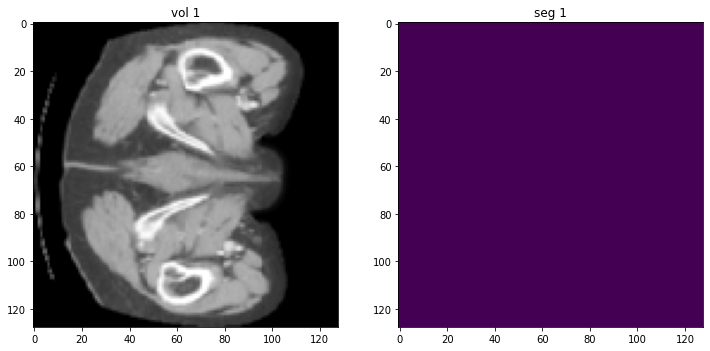

In [5]:
in_dir = '/content/drive/My Drive/Dataset/Data_Train_Test/'
model_dir = '/content/drive/My Drive/Dataset/results/results'

data_in  = pre_process_data(in_dir)
# data_in
show_sample(data_in)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
'''
    Dice loss: The Dice coefficient is widely used metric in computer vision community to calculate the similarity between two images.
                and then form a metric of training and testing.

'''
def cal_dice_matric(predicted, target):
  
    dice_value = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
    value = 1 - dice_value(predicted, target).item()
    return value

In [8]:
# saving checkpoint

def save_ckp(state, is_best, checkpoint_dir, best_model_dir):
    f_path = os.path.join(checkpoint_dir, 'checkpoint.pth')
    torch.save(state, f_path)
    if is_best:
        best_fpath = os.path.join(best_model_dir , 'best_metric_model.pth')
        shutil.copyfile(f_path, best_fpath)

In [9]:
save_loss_train = []
save_loss_test = []
save_metric_train = []
save_metric_test = []


def train(model, data_in, loss, optim,start_epoch, max_epochs, model_dir, test_interval=1 , device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")):
    best_metric = -1
    best_metric_epoch = -1
    tr_loader, ts_loader = data_in

    for epoch in tqdm(range(start_epoch, max_epochs)):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        train_epoch_loss = 0
        train_step = 0
        epoch_metric_train = 0
        for batch_data in tr_loader:
            
            train_step += 1

            volume = batch_data["vol"]
            label = batch_data["seg"]
            label = label != 0
            volume, label = (volume.to(device), label.to(device))

            optim.zero_grad()
            outputs = model(volume)
            
            train_loss = loss(outputs, label)
            
            train_loss.backward()
            optim.step()

            train_epoch_loss += train_loss.item()
            print(
                f"{train_step}/{len(tr_loader) // tr_loader.batch_size},"
                f"Train_loss: {train_loss.item():.4f}")

            train_metric = cal_dice_matric(outputs, label)
            epoch_metric_train += train_metric
            print(f'Train_dice: {train_metric:.4f}')

        print('-'*20)
        
        train_epoch_loss /= train_step

        print(f'Epoch_loss: {train_epoch_loss:.4f}')
        save_loss_train.append(train_epoch_loss)
        np.save(os.path.join(model_dir, 'loss_train.npy'), save_loss_train)
        
        epoch_metric_train /= train_step
        print(f'Epoch_metric: {epoch_metric_train:.4f}')

        save_metric_train.append(epoch_metric_train)
        np.save(os.path.join(model_dir, 'metric_train.npy'), save_metric_train)

        if (epoch + 1) % test_interval == 0:

            model.eval()
            with torch.no_grad():
                test_epoch_loss = 0
                test_metric = 0
                epoch_metric_test = 0
                test_step = 0

                for test_data in ts_loader:

                    test_step += 1

                    test_volume = test_data["vol"]
                    test_label = test_data["seg"]
                    test_label = test_label != 0
                    test_volume, test_label = (test_volume.to(device), test_label.to(device),)
                    
                    test_outputs = model(test_volume)
                    
                    test_loss = loss(outputs, test_label)
                    test_epoch_loss += test_loss.item()
                    test_metric = cal_dice_matric(test_outputs, test_label)
                    epoch_metric_test += test_metric
                    
                
                test_epoch_loss /= test_step
                print(f'test_loss_epoch: {test_epoch_loss:.4f}')
                save_loss_test.append(test_epoch_loss)
                np.save(os.path.join(model_dir, 'loss_test.npy'), save_loss_test)

                epoch_metric_test /= test_step
                print(f'test_dice_epoch: {epoch_metric_test:.4f}')
                save_metric_test.append(epoch_metric_test)
                np.save(os.path.join(model_dir, 'metric_test.npy'), save_metric_test)

                # adding checkpoint system in training
                is_best =0
                if epoch_metric_test > best_metric:
                    best_metric = epoch_metric_test
                    best_metric_epoch = epoch + 1
                    is_best =1
              
                checkpoint = {
                    'epoch': epoch + 1,
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict()
                }
                save_ckp(checkpoint, is_best, model_dir, model_dir)
                # Until here
                
                print(
                    f"current epoch: {epoch + 1} current mean dice: {test_metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )


    print(
        f"train completed, best_metric: {best_metric:.4f} "
        f"at epoch: {best_metric_epoch}")

In [10]:
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256), 
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)


In [11]:
loss_fn = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-5, weight_decay=1e-5, amsgrad=True)

In [12]:
def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath,map_location=torch.device("cpu"))
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, checkpoint['epoch']

In [13]:
start_epoch = 0
ckp_path = "/content/drive/MyDrive/Dataset/results/results/checkpoint.pth"
model, optimizer, start_epoch = load_ckp(ckp_path, model, optimizer)


In [14]:
if __name__ == '__main__':

    train(model, data_in, loss_fn, optimizer,start_epoch,start_epoch+ 50, model_dir,test_interval=3)

  0%|          | 0/50 [00:00<?, ?it/s]

----------
epoch 169/218
1/42,Train_loss: 0.2865
Train_dice: 0.7135
2/42,Train_loss: 0.2998
Train_dice: 0.7002
3/42,Train_loss: 0.3051
Train_dice: 0.6949
4/42,Train_loss: 0.3467
Train_dice: 0.6533
5/42,Train_loss: 0.2751
Train_dice: 0.7249
6/42,Train_loss: 0.5212
Train_dice: 0.4788
7/42,Train_loss: 0.3334
Train_dice: 0.6666
8/42,Train_loss: 0.3785
Train_dice: 0.6215
9/42,Train_loss: 0.1196
Train_dice: 0.8804
10/42,Train_loss: 0.5182
Train_dice: 0.4818
11/42,Train_loss: 0.1676
Train_dice: 0.8324
12/42,Train_loss: 0.1364
Train_dice: 0.8636
13/42,Train_loss: 0.2416
Train_dice: 0.7584
14/42,Train_loss: 0.3217
Train_dice: 0.6783
15/42,Train_loss: 0.0964
Train_dice: 0.9036
16/42,Train_loss: 0.3696
Train_dice: 0.6304
17/42,Train_loss: 0.1073
Train_dice: 0.8927
18/42,Train_loss: 0.4853
Train_dice: 0.5147
19/42,Train_loss: 0.1061
Train_dice: 0.8939
20/42,Train_loss: 0.1628
Train_dice: 0.8372
21/42,Train_loss: 0.2139
Train_dice: 0.7861
22/42,Train_loss: 0.2443
Train_dice: 0.7557
23/42,Train_loss

  2%|▏         | 1/50 [02:55<2:23:05, 175.22s/it]

----------
epoch 170/218
1/42,Train_loss: 0.2853
Train_dice: 0.7147
2/42,Train_loss: 0.2987
Train_dice: 0.7013
3/42,Train_loss: 0.3048
Train_dice: 0.6952
4/42,Train_loss: 0.3460
Train_dice: 0.6540
5/42,Train_loss: 0.2750
Train_dice: 0.7250
6/42,Train_loss: 0.5210
Train_dice: 0.4790
7/42,Train_loss: 0.3331
Train_dice: 0.6669
8/42,Train_loss: 0.3780
Train_dice: 0.6220
9/42,Train_loss: 0.1199
Train_dice: 0.8801
10/42,Train_loss: 0.5180
Train_dice: 0.4820
11/42,Train_loss: 0.1684
Train_dice: 0.8316
12/42,Train_loss: 0.1362
Train_dice: 0.8638
13/42,Train_loss: 0.2405
Train_dice: 0.7595
14/42,Train_loss: 0.3207
Train_dice: 0.6793
15/42,Train_loss: 0.0958
Train_dice: 0.9042
16/42,Train_loss: 0.3685
Train_dice: 0.6315
17/42,Train_loss: 0.1068
Train_dice: 0.8932
18/42,Train_loss: 0.4849
Train_dice: 0.5151
19/42,Train_loss: 0.1052
Train_dice: 0.8948
20/42,Train_loss: 0.1616
Train_dice: 0.8384
21/42,Train_loss: 0.2125
Train_dice: 0.7875
22/42,Train_loss: 0.2428
Train_dice: 0.7572
23/42,Train_loss

  4%|▍         | 2/50 [04:56<1:54:55, 143.65s/it]

42/42,Train_loss: 0.2230
Train_dice: 0.7770
--------------------
Epoch_loss: 0.2875
Epoch_metric: 0.7125
----------
epoch 171/218
1/42,Train_loss: 0.2840
Train_dice: 0.7160
2/42,Train_loss: 0.2973
Train_dice: 0.7027
3/42,Train_loss: 0.3029
Train_dice: 0.6971
4/42,Train_loss: 0.3448
Train_dice: 0.6552
5/42,Train_loss: 0.2729
Train_dice: 0.7271
6/42,Train_loss: 0.5209
Train_dice: 0.4791
7/42,Train_loss: 0.3314
Train_dice: 0.6686
8/42,Train_loss: 0.3768
Train_dice: 0.6232
9/42,Train_loss: 0.1178
Train_dice: 0.8822
10/42,Train_loss: 0.5178
Train_dice: 0.4822
11/42,Train_loss: 0.1671
Train_dice: 0.8329
12/42,Train_loss: 0.1349
Train_dice: 0.8651
13/42,Train_loss: 0.2403
Train_dice: 0.7597
14/42,Train_loss: 0.3208
Train_dice: 0.6792
15/42,Train_loss: 0.0954
Train_dice: 0.9046
16/42,Train_loss: 0.3680
Train_dice: 0.6320
17/42,Train_loss: 0.1065
Train_dice: 0.8935
18/42,Train_loss: 0.4846
Train_dice: 0.5154
19/42,Train_loss: 0.1052
Train_dice: 0.8948
20/42,Train_loss: 0.1612
Train_dice: 0.8388

  6%|▌         | 3/50 [07:24<1:54:02, 145.58s/it]

current epoch: 171 current mean dice: 0.7530
best mean dice: 0.7664 at epoch: 171
----------
epoch 172/218
1/42,Train_loss: 0.2834
Train_dice: 0.7166
2/42,Train_loss: 0.2965
Train_dice: 0.7035
3/42,Train_loss: 0.3022
Train_dice: 0.6978
4/42,Train_loss: 0.3439
Train_dice: 0.6561
5/42,Train_loss: 0.2720
Train_dice: 0.7280
6/42,Train_loss: 0.5208
Train_dice: 0.4792
7/42,Train_loss: 0.3303
Train_dice: 0.6697
8/42,Train_loss: 0.3759
Train_dice: 0.6241
9/42,Train_loss: 0.1176
Train_dice: 0.8824
10/42,Train_loss: 0.5177
Train_dice: 0.4823
11/42,Train_loss: 0.1645
Train_dice: 0.8355
12/42,Train_loss: 0.1337
Train_dice: 0.8663
13/42,Train_loss: 0.2378
Train_dice: 0.7622
14/42,Train_loss: 0.3184
Train_dice: 0.6816
15/42,Train_loss: 0.0938
Train_dice: 0.9062
16/42,Train_loss: 0.3668
Train_dice: 0.6332
17/42,Train_loss: 0.1049
Train_dice: 0.8951
18/42,Train_loss: 0.4843
Train_dice: 0.5157
19/42,Train_loss: 0.1040
Train_dice: 0.8960
20/42,Train_loss: 0.1600
Train_dice: 0.8400
21/42,Train_loss: 0.21

  8%|▊         | 4/50 [09:28<1:45:04, 137.06s/it]

42/42,Train_loss: 0.2215
Train_dice: 0.7785
--------------------
Epoch_loss: 0.2857
Epoch_metric: 0.7143
----------
epoch 173/218
1/42,Train_loss: 0.2820
Train_dice: 0.7180
2/42,Train_loss: 0.2953
Train_dice: 0.7047
3/42,Train_loss: 0.3013
Train_dice: 0.6987
4/42,Train_loss: 0.3429
Train_dice: 0.6571
5/42,Train_loss: 0.2720
Train_dice: 0.7280
6/42,Train_loss: 0.5206
Train_dice: 0.4794
7/42,Train_loss: 0.3300
Train_dice: 0.6700
8/42,Train_loss: 0.3752
Train_dice: 0.6248
9/42,Train_loss: 0.1167
Train_dice: 0.8833
10/42,Train_loss: 0.5176
Train_dice: 0.4824
11/42,Train_loss: 0.1656
Train_dice: 0.8344
12/42,Train_loss: 0.1334
Train_dice: 0.8666
13/42,Train_loss: 0.2381
Train_dice: 0.7619
14/42,Train_loss: 0.3180
Train_dice: 0.6820
15/42,Train_loss: 0.0941
Train_dice: 0.9059
16/42,Train_loss: 0.3659
Train_dice: 0.6341
17/42,Train_loss: 0.1048
Train_dice: 0.8952
18/42,Train_loss: 0.4839
Train_dice: 0.5161
19/42,Train_loss: 0.1032
Train_dice: 0.8968
20/42,Train_loss: 0.1584
Train_dice: 0.8416

 10%|█         | 5/50 [11:30<1:38:45, 131.68s/it]

42/42,Train_loss: 0.2199
Train_dice: 0.7801
--------------------
Epoch_loss: 0.2851
Epoch_metric: 0.7149
----------
epoch 174/218
1/42,Train_loss: 0.2807
Train_dice: 0.7193
2/42,Train_loss: 0.2939
Train_dice: 0.7061
3/42,Train_loss: 0.2997
Train_dice: 0.7003
4/42,Train_loss: 0.3418
Train_dice: 0.6582
5/42,Train_loss: 0.2695
Train_dice: 0.7305
6/42,Train_loss: 0.5205
Train_dice: 0.4795
7/42,Train_loss: 0.3286
Train_dice: 0.6714
8/42,Train_loss: 0.3740
Train_dice: 0.6260
9/42,Train_loss: 0.1153
Train_dice: 0.8847
10/42,Train_loss: 0.5174
Train_dice: 0.4826
11/42,Train_loss: 0.1628
Train_dice: 0.8372
12/42,Train_loss: 0.1313
Train_dice: 0.8687
13/42,Train_loss: 0.2365
Train_dice: 0.7635
14/42,Train_loss: 0.3168
Train_dice: 0.6832
15/42,Train_loss: 0.0925
Train_dice: 0.9075
16/42,Train_loss: 0.3653
Train_dice: 0.6347
17/42,Train_loss: 0.1037
Train_dice: 0.8963
18/42,Train_loss: 0.4836
Train_dice: 0.5164
19/42,Train_loss: 0.1026
Train_dice: 0.8974
20/42,Train_loss: 0.1580
Train_dice: 0.8420

 12%|█▏        | 6/50 [13:48<1:38:05, 133.75s/it]

current epoch: 174 current mean dice: 0.7570
best mean dice: 0.7687 at epoch: 174
----------
epoch 175/218
1/42,Train_loss: 0.2802
Train_dice: 0.7198
2/42,Train_loss: 0.2935
Train_dice: 0.7065
3/42,Train_loss: 0.2993
Train_dice: 0.7007
4/42,Train_loss: 0.3409
Train_dice: 0.6591
5/42,Train_loss: 0.2688
Train_dice: 0.7312
6/42,Train_loss: 0.5204
Train_dice: 0.4796
7/42,Train_loss: 0.3275
Train_dice: 0.6725
8/42,Train_loss: 0.3734
Train_dice: 0.6266
9/42,Train_loss: 0.1156
Train_dice: 0.8844
10/42,Train_loss: 0.5173
Train_dice: 0.4827
11/42,Train_loss: 0.1623
Train_dice: 0.8377
12/42,Train_loss: 0.1313
Train_dice: 0.8687
13/42,Train_loss: 0.2348
Train_dice: 0.7652
14/42,Train_loss: 0.3153
Train_dice: 0.6847
15/42,Train_loss: 0.0921
Train_dice: 0.9079
16/42,Train_loss: 0.3641
Train_dice: 0.6359
17/42,Train_loss: 0.1026
Train_dice: 0.8974
18/42,Train_loss: 0.4832
Train_dice: 0.5168
19/42,Train_loss: 0.1011
Train_dice: 0.8989
20/42,Train_loss: 0.1564
Train_dice: 0.8436
21/42,Train_loss: 0.20

 14%|█▍        | 7/50 [15:48<1:32:41, 129.35s/it]

42/42,Train_loss: 0.2177
Train_dice: 0.7823
--------------------
Epoch_loss: 0.2833
Epoch_metric: 0.7167
----------
epoch 176/218
1/42,Train_loss: 0.2789
Train_dice: 0.7211
2/42,Train_loss: 0.2925
Train_dice: 0.7075
3/42,Train_loss: 0.2980
Train_dice: 0.7020
4/42,Train_loss: 0.3402
Train_dice: 0.6598
5/42,Train_loss: 0.2677
Train_dice: 0.7323
6/42,Train_loss: 0.5203
Train_dice: 0.4797
7/42,Train_loss: 0.3266
Train_dice: 0.6734
8/42,Train_loss: 0.3726
Train_dice: 0.6274
9/42,Train_loss: 0.1139
Train_dice: 0.8861
10/42,Train_loss: 0.5172
Train_dice: 0.4828
11/42,Train_loss: 0.1621
Train_dice: 0.8379
12/42,Train_loss: 0.1302
Train_dice: 0.8698
13/42,Train_loss: 0.2342
Train_dice: 0.7658
14/42,Train_loss: 0.3150
Train_dice: 0.6850
15/42,Train_loss: 0.0919
Train_dice: 0.9081
16/42,Train_loss: 0.3633
Train_dice: 0.6367
17/42,Train_loss: 0.1026
Train_dice: 0.8974
18/42,Train_loss: 0.4829
Train_dice: 0.5171
19/42,Train_loss: 0.1011
Train_dice: 0.8989
20/42,Train_loss: 0.1558
Train_dice: 0.8442

 16%|█▌        | 8/50 [17:49<1:28:30, 126.43s/it]

42/42,Train_loss: 0.2170
Train_dice: 0.7830
--------------------
Epoch_loss: 0.2825
Epoch_metric: 0.7175
----------
epoch 177/218
1/42,Train_loss: 0.2783
Train_dice: 0.7217
2/42,Train_loss: 0.2913
Train_dice: 0.7087
3/42,Train_loss: 0.2966
Train_dice: 0.7034
4/42,Train_loss: 0.3390
Train_dice: 0.6610
5/42,Train_loss: 0.2660
Train_dice: 0.7340
6/42,Train_loss: 0.5202
Train_dice: 0.4798
7/42,Train_loss: 0.3254
Train_dice: 0.6746
8/42,Train_loss: 0.3718
Train_dice: 0.6282
9/42,Train_loss: 0.1134
Train_dice: 0.8866
10/42,Train_loss: 0.5171
Train_dice: 0.4829
11/42,Train_loss: 0.1594
Train_dice: 0.8406
12/42,Train_loss: 0.1291
Train_dice: 0.8709
13/42,Train_loss: 0.2327
Train_dice: 0.7673
14/42,Train_loss: 0.3133
Train_dice: 0.6867
15/42,Train_loss: 0.0900
Train_dice: 0.9100
16/42,Train_loss: 0.3624
Train_dice: 0.6376
17/42,Train_loss: 0.1012
Train_dice: 0.8988
18/42,Train_loss: 0.4826
Train_dice: 0.5174
19/42,Train_loss: 0.1003
Train_dice: 0.8997
20/42,Train_loss: 0.1550
Train_dice: 0.8450

 18%|█▊        | 9/50 [20:04<1:28:23, 129.35s/it]

current epoch: 177 current mean dice: 0.7590
best mean dice: 0.7710 at epoch: 177
----------
epoch 178/218
1/42,Train_loss: 0.2767
Train_dice: 0.7233
2/42,Train_loss: 0.2902
Train_dice: 0.7098
3/42,Train_loss: 0.2964
Train_dice: 0.7036
4/42,Train_loss: 0.3380
Train_dice: 0.6620
5/42,Train_loss: 0.2661
Train_dice: 0.7339
6/42,Train_loss: 0.5201
Train_dice: 0.4799
7/42,Train_loss: 0.3252
Train_dice: 0.6748
8/42,Train_loss: 0.3712
Train_dice: 0.6288
9/42,Train_loss: 0.1134
Train_dice: 0.8866
10/42,Train_loss: 0.5169
Train_dice: 0.4831
11/42,Train_loss: 0.1602
Train_dice: 0.8398
12/42,Train_loss: 0.1286
Train_dice: 0.8714
13/42,Train_loss: 0.2321
Train_dice: 0.7679
14/42,Train_loss: 0.3126
Train_dice: 0.6874
15/42,Train_loss: 0.0904
Train_dice: 0.9096
16/42,Train_loss: 0.3614
Train_dice: 0.6386
17/42,Train_loss: 0.1005
Train_dice: 0.8995
18/42,Train_loss: 0.4823
Train_dice: 0.5177
19/42,Train_loss: 0.0988
Train_dice: 0.9012
20/42,Train_loss: 0.1536
Train_dice: 0.8464
21/42,Train_loss: 0.20

 20%|██        | 10/50 [22:05<1:24:25, 126.63s/it]

42/42,Train_loss: 0.2143
Train_dice: 0.7857
--------------------
Epoch_loss: 0.2808
Epoch_metric: 0.7192
----------
epoch 179/218
1/42,Train_loss: 0.2750
Train_dice: 0.7250
2/42,Train_loss: 0.2884
Train_dice: 0.7116
3/42,Train_loss: 0.2943
Train_dice: 0.7057
4/42,Train_loss: 0.3368
Train_dice: 0.6632
5/42,Train_loss: 0.2636
Train_dice: 0.7364
6/42,Train_loss: 0.5200
Train_dice: 0.4800
7/42,Train_loss: 0.3233
Train_dice: 0.6767
8/42,Train_loss: 0.3697
Train_dice: 0.6303
9/42,Train_loss: 0.1108
Train_dice: 0.8892
10/42,Train_loss: 0.5167
Train_dice: 0.4833
11/42,Train_loss: 0.1574
Train_dice: 0.8426
12/42,Train_loss: 0.1268
Train_dice: 0.8732
13/42,Train_loss: 0.2306
Train_dice: 0.7694
14/42,Train_loss: 0.3111
Train_dice: 0.6889
15/42,Train_loss: 0.0888
Train_dice: 0.9112
16/42,Train_loss: 0.3606
Train_dice: 0.6394
17/42,Train_loss: 0.0997
Train_dice: 0.9003
18/42,Train_loss: 0.4818
Train_dice: 0.5182
19/42,Train_loss: 0.0986
Train_dice: 0.9014
20/42,Train_loss: 0.1525
Train_dice: 0.8475

 22%|██▏       | 11/50 [24:05<1:21:04, 124.72s/it]

42/42,Train_loss: 0.2134
Train_dice: 0.7866
--------------------
Epoch_loss: 0.2796
Epoch_metric: 0.7204
----------
epoch 180/218
1/42,Train_loss: 0.2742
Train_dice: 0.7258
2/42,Train_loss: 0.2877
Train_dice: 0.7123
3/42,Train_loss: 0.2935
Train_dice: 0.7065
4/42,Train_loss: 0.3358
Train_dice: 0.6642
5/42,Train_loss: 0.2631
Train_dice: 0.7369
6/42,Train_loss: 0.5198
Train_dice: 0.4802
7/42,Train_loss: 0.3222
Train_dice: 0.6778
8/42,Train_loss: 0.3689
Train_dice: 0.6311
9/42,Train_loss: 0.1105
Train_dice: 0.8895
10/42,Train_loss: 0.5166
Train_dice: 0.4834
11/42,Train_loss: 0.1568
Train_dice: 0.8432
12/42,Train_loss: 0.1261
Train_dice: 0.8739
13/42,Train_loss: 0.2289
Train_dice: 0.7711
14/42,Train_loss: 0.3098
Train_dice: 0.6902
15/42,Train_loss: 0.0880
Train_dice: 0.9120
16/42,Train_loss: 0.3593
Train_dice: 0.6407
17/42,Train_loss: 0.0985
Train_dice: 0.9015
18/42,Train_loss: 0.4815
Train_dice: 0.5185
19/42,Train_loss: 0.0972
Train_dice: 0.9028
20/42,Train_loss: 0.1512
Train_dice: 0.8488

 24%|██▍       | 12/50 [26:21<1:21:11, 128.21s/it]

current epoch: 180 current mean dice: 0.7615
best mean dice: 0.7734 at epoch: 180
----------
epoch 181/218
1/42,Train_loss: 0.2729
Train_dice: 0.7271
2/42,Train_loss: 0.2864
Train_dice: 0.7136
3/42,Train_loss: 0.2921
Train_dice: 0.7079
4/42,Train_loss: 0.3349
Train_dice: 0.6651
5/42,Train_loss: 0.2615
Train_dice: 0.7385
6/42,Train_loss: 0.5197
Train_dice: 0.4803
7/42,Train_loss: 0.3211
Train_dice: 0.6789
8/42,Train_loss: 0.3679
Train_dice: 0.6321
9/42,Train_loss: 0.1092
Train_dice: 0.8908
10/42,Train_loss: 0.5165
Train_dice: 0.4835
11/42,Train_loss: 0.1555
Train_dice: 0.8445
12/42,Train_loss: 0.1251
Train_dice: 0.8749
13/42,Train_loss: 0.2279
Train_dice: 0.7721
14/42,Train_loss: 0.3092
Train_dice: 0.6908
15/42,Train_loss: 0.0873
Train_dice: 0.9127
16/42,Train_loss: 0.3585
Train_dice: 0.6415
17/42,Train_loss: 0.0979
Train_dice: 0.9021
18/42,Train_loss: 0.4812
Train_dice: 0.5188
19/42,Train_loss: 0.0966
Train_dice: 0.9034
20/42,Train_loss: 0.1503
Train_dice: 0.8497
21/42,Train_loss: 0.20

 26%|██▌       | 13/50 [28:22<1:17:42, 126.01s/it]

42/42,Train_loss: 0.2110
Train_dice: 0.7890
--------------------
Epoch_loss: 0.2779
Epoch_metric: 0.7221
----------
epoch 182/218
1/42,Train_loss: 0.2720
Train_dice: 0.7280
2/42,Train_loss: 0.2853
Train_dice: 0.7147
3/42,Train_loss: 0.2911
Train_dice: 0.7089
4/42,Train_loss: 0.3339
Train_dice: 0.6661
5/42,Train_loss: 0.2605
Train_dice: 0.7395
6/42,Train_loss: 0.5196
Train_dice: 0.4804
7/42,Train_loss: 0.3199
Train_dice: 0.6801
8/42,Train_loss: 0.3670
Train_dice: 0.6330
9/42,Train_loss: 0.1084
Train_dice: 0.8916
10/42,Train_loss: 0.5163
Train_dice: 0.4837
11/42,Train_loss: 0.1542
Train_dice: 0.8458
12/42,Train_loss: 0.1240
Train_dice: 0.8760
13/42,Train_loss: 0.2265
Train_dice: 0.7735
14/42,Train_loss: 0.3077
Train_dice: 0.6923
15/42,Train_loss: 0.0863
Train_dice: 0.9137
16/42,Train_loss: 0.3575
Train_dice: 0.6425
17/42,Train_loss: 0.0970
Train_dice: 0.9030
18/42,Train_loss: 0.4808
Train_dice: 0.5192
19/42,Train_loss: 0.0959
Train_dice: 0.9041
20/42,Train_loss: 0.1494
Train_dice: 0.8506

 28%|██▊       | 14/50 [30:22<1:14:30, 124.19s/it]

42/42,Train_loss: 0.2096
Train_dice: 0.7904
--------------------
Epoch_loss: 0.2770
Epoch_metric: 0.7230
----------
epoch 183/218
1/42,Train_loss: 0.2708
Train_dice: 0.7292
2/42,Train_loss: 0.2843
Train_dice: 0.7157
3/42,Train_loss: 0.2898
Train_dice: 0.7102
4/42,Train_loss: 0.3328
Train_dice: 0.6672
5/42,Train_loss: 0.2593
Train_dice: 0.7407
6/42,Train_loss: 0.5195
Train_dice: 0.4805
7/42,Train_loss: 0.3190
Train_dice: 0.6810
8/42,Train_loss: 0.3661
Train_dice: 0.6339
9/42,Train_loss: 0.1077
Train_dice: 0.8923
10/42,Train_loss: 0.5162
Train_dice: 0.4838
11/42,Train_loss: 0.1537
Train_dice: 0.8463
12/42,Train_loss: 0.1234
Train_dice: 0.8766
13/42,Train_loss: 0.2253
Train_dice: 0.7747
14/42,Train_loss: 0.3067
Train_dice: 0.6933
15/42,Train_loss: 0.0858
Train_dice: 0.9142
16/42,Train_loss: 0.3566
Train_dice: 0.6434
17/42,Train_loss: 0.0961
Train_dice: 0.9039
18/42,Train_loss: 0.4804
Train_dice: 0.5196
19/42,Train_loss: 0.0948
Train_dice: 0.9052
20/42,Train_loss: 0.1481
Train_dice: 0.8519

 30%|███       | 15/50 [32:37<1:14:21, 127.47s/it]

current epoch: 183 current mean dice: 0.7629
best mean dice: 0.7737 at epoch: 183
----------
epoch 184/218
1/42,Train_loss: 0.2695
Train_dice: 0.7305
2/42,Train_loss: 0.2829
Train_dice: 0.7171
3/42,Train_loss: 0.2891
Train_dice: 0.7109
4/42,Train_loss: 0.3319
Train_dice: 0.6681
5/42,Train_loss: 0.2586
Train_dice: 0.7414
6/42,Train_loss: 0.5194
Train_dice: 0.4806
7/42,Train_loss: 0.3181
Train_dice: 0.6819
8/42,Train_loss: 0.3652
Train_dice: 0.6348
9/42,Train_loss: 0.1074
Train_dice: 0.8926
10/42,Train_loss: 0.5161
Train_dice: 0.4839
11/42,Train_loss: 0.1526
Train_dice: 0.8474
12/42,Train_loss: 0.1222
Train_dice: 0.8778
13/42,Train_loss: 0.2247
Train_dice: 0.7753
14/42,Train_loss: 0.3056
Train_dice: 0.6944
15/42,Train_loss: 0.0852
Train_dice: 0.9148
16/42,Train_loss: 0.3557
Train_dice: 0.6443
17/42,Train_loss: 0.0955
Train_dice: 0.9045
18/42,Train_loss: 0.4801
Train_dice: 0.5199
19/42,Train_loss: 0.0942
Train_dice: 0.9058
20/42,Train_loss: 0.1473
Train_dice: 0.8527
21/42,Train_loss: 0.19

 32%|███▏      | 16/50 [34:38<1:11:05, 125.46s/it]

42/42,Train_loss: 0.2075
Train_dice: 0.7925
--------------------
Epoch_loss: 0.2754
Epoch_metric: 0.7246
----------
epoch 185/218
1/42,Train_loss: 0.2684
Train_dice: 0.7316
2/42,Train_loss: 0.2820
Train_dice: 0.7180
3/42,Train_loss: 0.2876
Train_dice: 0.7124
4/42,Train_loss: 0.3308
Train_dice: 0.6692
5/42,Train_loss: 0.2569
Train_dice: 0.7431
6/42,Train_loss: 0.5193
Train_dice: 0.4807
7/42,Train_loss: 0.3167
Train_dice: 0.6833
8/42,Train_loss: 0.3645
Train_dice: 0.6355
9/42,Train_loss: 0.1057
Train_dice: 0.8943
10/42,Train_loss: 0.5160
Train_dice: 0.4840
11/42,Train_loss: 0.1517
Train_dice: 0.8483
12/42,Train_loss: 0.1214
Train_dice: 0.8786
13/42,Train_loss: 0.2238
Train_dice: 0.7762
14/42,Train_loss: 0.3048
Train_dice: 0.6952
15/42,Train_loss: 0.0846
Train_dice: 0.9154
16/42,Train_loss: 0.3548
Train_dice: 0.6452
17/42,Train_loss: 0.0947
Train_dice: 0.9053
18/42,Train_loss: 0.4797
Train_dice: 0.5203
19/42,Train_loss: 0.0933
Train_dice: 0.9067
20/42,Train_loss: 0.1465
Train_dice: 0.8535

 34%|███▍      | 17/50 [36:35<1:07:33, 122.84s/it]

42/42,Train_loss: 0.2065
Train_dice: 0.7935
--------------------
Epoch_loss: 0.2745
Epoch_metric: 0.7255
----------
epoch 186/218
1/42,Train_loss: 0.2672
Train_dice: 0.7328
2/42,Train_loss: 0.2807
Train_dice: 0.7193
3/42,Train_loss: 0.2867
Train_dice: 0.7133
4/42,Train_loss: 0.3299
Train_dice: 0.6701
5/42,Train_loss: 0.2562
Train_dice: 0.7438
6/42,Train_loss: 0.5191
Train_dice: 0.4809
7/42,Train_loss: 0.3160
Train_dice: 0.6840
8/42,Train_loss: 0.3636
Train_dice: 0.6364
9/42,Train_loss: 0.1059
Train_dice: 0.8941
10/42,Train_loss: 0.5158
Train_dice: 0.4842
11/42,Train_loss: 0.1504
Train_dice: 0.8496
12/42,Train_loss: 0.1207
Train_dice: 0.8793
13/42,Train_loss: 0.2220
Train_dice: 0.7780
14/42,Train_loss: 0.3033
Train_dice: 0.6967
15/42,Train_loss: 0.0836
Train_dice: 0.9164
16/42,Train_loss: 0.3536
Train_dice: 0.6464
17/42,Train_loss: 0.0938
Train_dice: 0.9062
18/42,Train_loss: 0.4794
Train_dice: 0.5206
19/42,Train_loss: 0.0928
Train_dice: 0.9072
20/42,Train_loss: 0.1450
Train_dice: 0.8550

 36%|███▌      | 18/50 [38:46<1:06:49, 125.28s/it]

current epoch: 186 current mean dice: 0.7676
best mean dice: 0.7785 at epoch: 186
----------
epoch 187/218
1/42,Train_loss: 0.2659
Train_dice: 0.7341
2/42,Train_loss: 0.2795
Train_dice: 0.7205
3/42,Train_loss: 0.2854
Train_dice: 0.7146
4/42,Train_loss: 0.3288
Train_dice: 0.6712
5/42,Train_loss: 0.2547
Train_dice: 0.7453
6/42,Train_loss: 0.5190
Train_dice: 0.4810
7/42,Train_loss: 0.3147
Train_dice: 0.6853
8/42,Train_loss: 0.3626
Train_dice: 0.6374
9/42,Train_loss: 0.1044
Train_dice: 0.8956
10/42,Train_loss: 0.5156
Train_dice: 0.4844
11/42,Train_loss: 0.1501
Train_dice: 0.8499
12/42,Train_loss: 0.1201
Train_dice: 0.8799
13/42,Train_loss: 0.2219
Train_dice: 0.7781
14/42,Train_loss: 0.3026
Train_dice: 0.6974
15/42,Train_loss: 0.0837
Train_dice: 0.9163
16/42,Train_loss: 0.3529
Train_dice: 0.6471
17/42,Train_loss: 0.0936
Train_dice: 0.9064
18/42,Train_loss: 0.4790
Train_dice: 0.5210
19/42,Train_loss: 0.0920
Train_dice: 0.9080
20/42,Train_loss: 0.1445
Train_dice: 0.8555
21/42,Train_loss: 0.19

 38%|███▊      | 19/50 [40:43<1:03:29, 122.90s/it]

42/42,Train_loss: 0.2041
Train_dice: 0.7959
--------------------
Epoch_loss: 0.2730
Epoch_metric: 0.7270
----------
epoch 188/218
1/42,Train_loss: 0.2650
Train_dice: 0.7350
2/42,Train_loss: 0.2784
Train_dice: 0.7216
3/42,Train_loss: 0.2845
Train_dice: 0.7155
4/42,Train_loss: 0.3278
Train_dice: 0.6722
5/42,Train_loss: 0.2534
Train_dice: 0.7466
6/42,Train_loss: 0.5190
Train_dice: 0.4810
7/42,Train_loss: 0.3134
Train_dice: 0.6866
8/42,Train_loss: 0.3615
Train_dice: 0.6385
9/42,Train_loss: 0.1035
Train_dice: 0.8965
10/42,Train_loss: 0.5156
Train_dice: 0.4844
11/42,Train_loss: 0.1480
Train_dice: 0.8520
12/42,Train_loss: 0.1188
Train_dice: 0.8812
13/42,Train_loss: 0.2198
Train_dice: 0.7802
14/42,Train_loss: 0.3013
Train_dice: 0.6987
15/42,Train_loss: 0.0821
Train_dice: 0.9179
16/42,Train_loss: 0.3518
Train_dice: 0.6482
17/42,Train_loss: 0.0924
Train_dice: 0.9076
18/42,Train_loss: 0.4786
Train_dice: 0.5214
19/42,Train_loss: 0.0917
Train_dice: 0.9083
20/42,Train_loss: 0.1435
Train_dice: 0.8565

 40%|████      | 20/50 [42:40<1:00:28, 120.96s/it]

42/42,Train_loss: 0.2029
Train_dice: 0.7971
--------------------
Epoch_loss: 0.2720
Epoch_metric: 0.7280
----------
epoch 189/218
1/42,Train_loss: 0.2637
Train_dice: 0.7363
2/42,Train_loss: 0.2773
Train_dice: 0.7227
3/42,Train_loss: 0.2832
Train_dice: 0.7168
4/42,Train_loss: 0.3268
Train_dice: 0.6732
5/42,Train_loss: 0.2525
Train_dice: 0.7475
6/42,Train_loss: 0.5189
Train_dice: 0.4811
7/42,Train_loss: 0.3128
Train_dice: 0.6872
8/42,Train_loss: 0.3608
Train_dice: 0.6392
9/42,Train_loss: 0.1038
Train_dice: 0.8962
10/42,Train_loss: 0.5154
Train_dice: 0.4846
11/42,Train_loss: 0.1479
Train_dice: 0.8521
12/42,Train_loss: 0.1187
Train_dice: 0.8813
13/42,Train_loss: 0.2190
Train_dice: 0.7810
14/42,Train_loss: 0.3002
Train_dice: 0.6998
15/42,Train_loss: 0.0824
Train_dice: 0.9176
16/42,Train_loss: 0.3508
Train_dice: 0.6492
17/42,Train_loss: 0.0919
Train_dice: 0.9081
18/42,Train_loss: 0.4783
Train_dice: 0.5217
19/42,Train_loss: 0.0904
Train_dice: 0.9096
20/42,Train_loss: 0.1423
Train_dice: 0.8577

 42%|████▏     | 21/50 [44:51<1:00:00, 124.15s/it]

current epoch: 189 current mean dice: 0.7728
best mean dice: 0.7828 at epoch: 189
----------
epoch 190/218
1/42,Train_loss: 0.2625
Train_dice: 0.7375
2/42,Train_loss: 0.2761
Train_dice: 0.7239
3/42,Train_loss: 0.2821
Train_dice: 0.7179
4/42,Train_loss: 0.3258
Train_dice: 0.6742
5/42,Train_loss: 0.2510
Train_dice: 0.7490
6/42,Train_loss: 0.5187
Train_dice: 0.4813
7/42,Train_loss: 0.3113
Train_dice: 0.6887
8/42,Train_loss: 0.3599
Train_dice: 0.6401
9/42,Train_loss: 0.1020
Train_dice: 0.8980
10/42,Train_loss: 0.5153
Train_dice: 0.4847
11/42,Train_loss: 0.1471
Train_dice: 0.8529
12/42,Train_loss: 0.1174
Train_dice: 0.8826
13/42,Train_loss: 0.2181
Train_dice: 0.7819
14/42,Train_loss: 0.2996
Train_dice: 0.7004
15/42,Train_loss: 0.0813
Train_dice: 0.9187
16/42,Train_loss: 0.3500
Train_dice: 0.6500
17/42,Train_loss: 0.0913
Train_dice: 0.9087
18/42,Train_loss: 0.4780
Train_dice: 0.5220
19/42,Train_loss: 0.0903
Train_dice: 0.9097
20/42,Train_loss: 0.1418
Train_dice: 0.8582
21/42,Train_loss: 0.19

 44%|████▍     | 22/50 [46:49<57:03, 122.28s/it]  

42/42,Train_loss: 0.2010
Train_dice: 0.7990
--------------------
Epoch_loss: 0.2705
Epoch_metric: 0.7295
----------
epoch 191/218
1/42,Train_loss: 0.2615
Train_dice: 0.7385
2/42,Train_loss: 0.2751
Train_dice: 0.7249
3/42,Train_loss: 0.2811
Train_dice: 0.7189
4/42,Train_loss: 0.3248
Train_dice: 0.6752
5/42,Train_loss: 0.2503
Train_dice: 0.7497
6/42,Train_loss: 0.5186
Train_dice: 0.4814
7/42,Train_loss: 0.3106
Train_dice: 0.6894
8/42,Train_loss: 0.3590
Train_dice: 0.6410
9/42,Train_loss: 0.1018
Train_dice: 0.8982
10/42,Train_loss: 0.5152
Train_dice: 0.4848
11/42,Train_loss: 0.1455
Train_dice: 0.8545
12/42,Train_loss: 0.1164
Train_dice: 0.8836
13/42,Train_loss: 0.2163
Train_dice: 0.7837
14/42,Train_loss: 0.2977
Train_dice: 0.7023
15/42,Train_loss: 0.0801
Train_dice: 0.9199
16/42,Train_loss: 0.3488
Train_dice: 0.6512
17/42,Train_loss: 0.0903
Train_dice: 0.9097
18/42,Train_loss: 0.4776
Train_dice: 0.5224
19/42,Train_loss: 0.0892
Train_dice: 0.9108
20/42,Train_loss: 0.1405
Train_dice: 0.8595

 46%|████▌     | 23/50 [48:47<54:22, 120.84s/it]

42/42,Train_loss: 0.1998
Train_dice: 0.8002
--------------------
Epoch_loss: 0.2696
Epoch_metric: 0.7304
----------
epoch 192/218
1/42,Train_loss: 0.2606
Train_dice: 0.7394
2/42,Train_loss: 0.2743
Train_dice: 0.7257
3/42,Train_loss: 0.2802
Train_dice: 0.7198
4/42,Train_loss: 0.3239
Train_dice: 0.6761
5/42,Train_loss: 0.2495
Train_dice: 0.7505
6/42,Train_loss: 0.5185
Train_dice: 0.4815
7/42,Train_loss: 0.3094
Train_dice: 0.6906
8/42,Train_loss: 0.3582
Train_dice: 0.6418
9/42,Train_loss: 0.1017
Train_dice: 0.8983
10/42,Train_loss: 0.5150
Train_dice: 0.4850
11/42,Train_loss: 0.1453
Train_dice: 0.8547
12/42,Train_loss: 0.1160
Train_dice: 0.8840
13/42,Train_loss: 0.2159
Train_dice: 0.7841
14/42,Train_loss: 0.2973
Train_dice: 0.7027
15/42,Train_loss: 0.0803
Train_dice: 0.9197
16/42,Train_loss: 0.3481
Train_dice: 0.6519
17/42,Train_loss: 0.0899
Train_dice: 0.9101
18/42,Train_loss: 0.4772
Train_dice: 0.5228
19/42,Train_loss: 0.0884
Train_dice: 0.9116
20/42,Train_loss: 0.1395
Train_dice: 0.8605

 48%|████▊     | 24/50 [50:59<53:53, 124.35s/it]

current epoch: 192 current mean dice: 0.7749
best mean dice: 0.7844 at epoch: 192
----------
epoch 193/218
1/42,Train_loss: 0.2593
Train_dice: 0.7407
2/42,Train_loss: 0.2730
Train_dice: 0.7270
3/42,Train_loss: 0.2791
Train_dice: 0.7209
4/42,Train_loss: 0.3227
Train_dice: 0.6773
5/42,Train_loss: 0.2482
Train_dice: 0.7518
6/42,Train_loss: 0.5185
Train_dice: 0.4815
7/42,Train_loss: 0.3084
Train_dice: 0.6916
8/42,Train_loss: 0.3572
Train_dice: 0.6428
9/42,Train_loss: 0.1003
Train_dice: 0.8997
10/42,Train_loss: 0.5149
Train_dice: 0.4851
11/42,Train_loss: 0.1440
Train_dice: 0.8560
12/42,Train_loss: 0.1144
Train_dice: 0.8856
13/42,Train_loss: 0.2150
Train_dice: 0.7850
14/42,Train_loss: 0.2961
Train_dice: 0.7039
15/42,Train_loss: 0.0793
Train_dice: 0.9207
16/42,Train_loss: 0.3471
Train_dice: 0.6529
17/42,Train_loss: 0.0890
Train_dice: 0.9110
18/42,Train_loss: 0.4769
Train_dice: 0.5231
19/42,Train_loss: 0.0884
Train_dice: 0.9116
20/42,Train_loss: 0.1391
Train_dice: 0.8609
21/42,Train_loss: 0.18

 50%|█████     | 25/50 [52:57<51:02, 122.51s/it]

42/42,Train_loss: 0.1977
Train_dice: 0.8023
--------------------
Epoch_loss: 0.2681
Epoch_metric: 0.7319
----------
epoch 194/218
1/42,Train_loss: 0.2583
Train_dice: 0.7417
2/42,Train_loss: 0.2718
Train_dice: 0.7282
3/42,Train_loss: 0.2778
Train_dice: 0.7222
4/42,Train_loss: 0.3218
Train_dice: 0.6782
5/42,Train_loss: 0.2468
Train_dice: 0.7532
6/42,Train_loss: 0.5184
Train_dice: 0.4816
7/42,Train_loss: 0.3075
Train_dice: 0.6925
8/42,Train_loss: 0.3563
Train_dice: 0.6437
9/42,Train_loss: 0.0996
Train_dice: 0.9004
10/42,Train_loss: 0.5148
Train_dice: 0.4852
11/42,Train_loss: 0.1432
Train_dice: 0.8568
12/42,Train_loss: 0.1138
Train_dice: 0.8862
13/42,Train_loss: 0.2132
Train_dice: 0.7868
14/42,Train_loss: 0.2950
Train_dice: 0.7050
15/42,Train_loss: 0.0783
Train_dice: 0.9217
16/42,Train_loss: 0.3461
Train_dice: 0.6539
17/42,Train_loss: 0.0883
Train_dice: 0.9117
18/42,Train_loss: 0.4765
Train_dice: 0.5235
19/42,Train_loss: 0.0874
Train_dice: 0.9126
20/42,Train_loss: 0.1376
Train_dice: 0.8624

 52%|█████▏    | 26/50 [54:54<48:17, 120.71s/it]

42/42,Train_loss: 0.1967
Train_dice: 0.8033
--------------------
Epoch_loss: 0.2674
Epoch_metric: 0.7326
----------
epoch 195/218
1/42,Train_loss: 0.2580
Train_dice: 0.7420
2/42,Train_loss: 0.2717
Train_dice: 0.7283
3/42,Train_loss: 0.2773
Train_dice: 0.7227
4/42,Train_loss: 0.3212
Train_dice: 0.6788
5/42,Train_loss: 0.2461
Train_dice: 0.7539
6/42,Train_loss: 0.5183
Train_dice: 0.4817
7/42,Train_loss: 0.3064
Train_dice: 0.6936
8/42,Train_loss: 0.3558
Train_dice: 0.6442
9/42,Train_loss: 0.1005
Train_dice: 0.8995
10/42,Train_loss: 0.5147
Train_dice: 0.4853
11/42,Train_loss: 0.1431
Train_dice: 0.8569
12/42,Train_loss: 0.1135
Train_dice: 0.8865
13/42,Train_loss: 0.2123
Train_dice: 0.7877
14/42,Train_loss: 0.2939
Train_dice: 0.7061
15/42,Train_loss: 0.0787
Train_dice: 0.9213
16/42,Train_loss: 0.3452
Train_dice: 0.6548
17/42,Train_loss: 0.0879
Train_dice: 0.9121
18/42,Train_loss: 0.4762
Train_dice: 0.5238
19/42,Train_loss: 0.0868
Train_dice: 0.9132
20/42,Train_loss: 0.1368
Train_dice: 0.8632

 54%|█████▍    | 27/50 [57:07<47:38, 124.28s/it]

current epoch: 195 current mean dice: 0.7793
best mean dice: 0.7894 at epoch: 195
----------
epoch 196/218
1/42,Train_loss: 0.2566
Train_dice: 0.7434
2/42,Train_loss: 0.2701
Train_dice: 0.7299
3/42,Train_loss: 0.2759
Train_dice: 0.7241
4/42,Train_loss: 0.3198
Train_dice: 0.6802
5/42,Train_loss: 0.2444
Train_dice: 0.7556
6/42,Train_loss: 0.5182
Train_dice: 0.4818
7/42,Train_loss: 0.3052
Train_dice: 0.6948
8/42,Train_loss: 0.3544
Train_dice: 0.6456
9/42,Train_loss: 0.0979
Train_dice: 0.9021
10/42,Train_loss: 0.5146
Train_dice: 0.4854
11/42,Train_loss: 0.1409
Train_dice: 0.8591
12/42,Train_loss: 0.1119
Train_dice: 0.8881
13/42,Train_loss: 0.2116
Train_dice: 0.7884
14/42,Train_loss: 0.2928
Train_dice: 0.7072
15/42,Train_loss: 0.0776
Train_dice: 0.9224
16/42,Train_loss: 0.3441
Train_dice: 0.6559
17/42,Train_loss: 0.0873
Train_dice: 0.9127
18/42,Train_loss: 0.4758
Train_dice: 0.5242
19/42,Train_loss: 0.0863
Train_dice: 0.9137
20/42,Train_loss: 0.1366
Train_dice: 0.8634
21/42,Train_loss: 0.18

 56%|█████▌    | 28/50 [59:01<44:32, 121.47s/it]

42/42,Train_loss: 0.1945
Train_dice: 0.8055
--------------------
Epoch_loss: 0.2657
Epoch_metric: 0.7343
----------
epoch 197/218
1/42,Train_loss: 0.2549
Train_dice: 0.7451
2/42,Train_loss: 0.2686
Train_dice: 0.7314
3/42,Train_loss: 0.2749
Train_dice: 0.7251
4/42,Train_loss: 0.3188
Train_dice: 0.6812
5/42,Train_loss: 0.2440
Train_dice: 0.7560
6/42,Train_loss: 0.5180
Train_dice: 0.4820
7/42,Train_loss: 0.3045
Train_dice: 0.6955
8/42,Train_loss: 0.3536
Train_dice: 0.6464
9/42,Train_loss: 0.0987
Train_dice: 0.9013
10/42,Train_loss: 0.5144
Train_dice: 0.4856
11/42,Train_loss: 0.1410
Train_dice: 0.8590
12/42,Train_loss: 0.1120
Train_dice: 0.8880
13/42,Train_loss: 0.2107
Train_dice: 0.7893
14/42,Train_loss: 0.2921
Train_dice: 0.7079
15/42,Train_loss: 0.0770
Train_dice: 0.9230
16/42,Train_loss: 0.3431
Train_dice: 0.6569
17/42,Train_loss: 0.0861
Train_dice: 0.9139
18/42,Train_loss: 0.4755
Train_dice: 0.5245
19/42,Train_loss: 0.0851
Train_dice: 0.9149
20/42,Train_loss: 0.1353
Train_dice: 0.8647

 58%|█████▊    | 29/50 [1:00:59<42:03, 120.15s/it]

42/42,Train_loss: 0.1942
Train_dice: 0.8058
--------------------
Epoch_loss: 0.2650
Epoch_metric: 0.7350
----------
epoch 198/218
1/42,Train_loss: 0.2541
Train_dice: 0.7459
2/42,Train_loss: 0.2676
Train_dice: 0.7324
3/42,Train_loss: 0.2738
Train_dice: 0.7262
4/42,Train_loss: 0.3176
Train_dice: 0.6824
5/42,Train_loss: 0.2421
Train_dice: 0.7579
6/42,Train_loss: 0.5179
Train_dice: 0.4821
7/42,Train_loss: 0.3029
Train_dice: 0.6971
8/42,Train_loss: 0.3525
Train_dice: 0.6475
9/42,Train_loss: 0.0960
Train_dice: 0.9040
10/42,Train_loss: 0.5143
Train_dice: 0.4857
11/42,Train_loss: 0.1386
Train_dice: 0.8614
12/42,Train_loss: 0.1104
Train_dice: 0.8896
13/42,Train_loss: 0.2094
Train_dice: 0.7906
14/42,Train_loss: 0.2905
Train_dice: 0.7095
15/42,Train_loss: 0.0762
Train_dice: 0.9238
16/42,Train_loss: 0.3422
Train_dice: 0.6578
17/42,Train_loss: 0.0854
Train_dice: 0.9146
18/42,Train_loss: 0.4751
Train_dice: 0.5249
19/42,Train_loss: 0.0843
Train_dice: 0.9157
20/42,Train_loss: 0.1342
Train_dice: 0.8658

 60%|██████    | 30/50 [1:03:11<41:18, 123.91s/it]

current epoch: 198 current mean dice: 0.7800
best mean dice: 0.7897 at epoch: 198
----------
epoch 199/218
1/42,Train_loss: 0.2526
Train_dice: 0.7474
2/42,Train_loss: 0.2662
Train_dice: 0.7338
3/42,Train_loss: 0.2729
Train_dice: 0.7271
4/42,Train_loss: 0.3167
Train_dice: 0.6833
5/42,Train_loss: 0.2424
Train_dice: 0.7576
6/42,Train_loss: 0.5179
Train_dice: 0.4821
7/42,Train_loss: 0.3023
Train_dice: 0.6977
8/42,Train_loss: 0.3519
Train_dice: 0.6481
9/42,Train_loss: 0.0963
Train_dice: 0.9037
10/42,Train_loss: 0.5142
Train_dice: 0.4858
11/42,Train_loss: 0.1387
Train_dice: 0.8613
12/42,Train_loss: 0.1102
Train_dice: 0.8898
13/42,Train_loss: 0.2079
Train_dice: 0.7921
14/42,Train_loss: 0.2894
Train_dice: 0.7106
15/42,Train_loss: 0.0750
Train_dice: 0.9250
16/42,Train_loss: 0.3410
Train_dice: 0.6590
17/42,Train_loss: 0.0846
Train_dice: 0.9154
18/42,Train_loss: 0.4747
Train_dice: 0.5253
19/42,Train_loss: 0.0839
Train_dice: 0.9161
20/42,Train_loss: 0.1331
Train_dice: 0.8669
21/42,Train_loss: 0.18

 62%|██████▏   | 31/50 [1:05:10<38:47, 122.48s/it]

42/42,Train_loss: 0.1917
Train_dice: 0.8083
--------------------
Epoch_loss: 0.2631
Epoch_metric: 0.7369
----------
epoch 200/218
1/42,Train_loss: 0.2518
Train_dice: 0.7482
2/42,Train_loss: 0.2654
Train_dice: 0.7346
3/42,Train_loss: 0.2715
Train_dice: 0.7285
4/42,Train_loss: 0.3158
Train_dice: 0.6842
5/42,Train_loss: 0.2396
Train_dice: 0.7604
6/42,Train_loss: 0.5177
Train_dice: 0.4823
7/42,Train_loss: 0.3007
Train_dice: 0.6993
8/42,Train_loss: 0.3505
Train_dice: 0.6495
9/42,Train_loss: 0.0949
Train_dice: 0.9051
10/42,Train_loss: 0.5140
Train_dice: 0.4860
11/42,Train_loss: 0.1368
Train_dice: 0.8632
12/42,Train_loss: 0.1088
Train_dice: 0.8912
13/42,Train_loss: 0.2070
Train_dice: 0.7930
14/42,Train_loss: 0.2886
Train_dice: 0.7114
15/42,Train_loss: 0.0748
Train_dice: 0.9252
16/42,Train_loss: 0.3402
Train_dice: 0.6598
17/42,Train_loss: 0.0840
Train_dice: 0.9160
18/42,Train_loss: 0.4744
Train_dice: 0.5256
19/42,Train_loss: 0.0832
Train_dice: 0.9168
20/42,Train_loss: 0.1323
Train_dice: 0.8677

 64%|██████▍   | 32/50 [1:07:09<36:23, 121.33s/it]

42/42,Train_loss: 0.1900
Train_dice: 0.8100
--------------------
Epoch_loss: 0.2622
Epoch_metric: 0.7378
----------
epoch 201/218
1/42,Train_loss: 0.2502
Train_dice: 0.7498
2/42,Train_loss: 0.2638
Train_dice: 0.7362
3/42,Train_loss: 0.2705
Train_dice: 0.7295
4/42,Train_loss: 0.3144
Train_dice: 0.6856
5/42,Train_loss: 0.2393
Train_dice: 0.7607
6/42,Train_loss: 0.5176
Train_dice: 0.4824
7/42,Train_loss: 0.3000
Train_dice: 0.7000
8/42,Train_loss: 0.3499
Train_dice: 0.6501
9/42,Train_loss: 0.0946
Train_dice: 0.9054
10/42,Train_loss: 0.5139
Train_dice: 0.4861
11/42,Train_loss: 0.1365
Train_dice: 0.8635
12/42,Train_loss: 0.1080
Train_dice: 0.8920
13/42,Train_loss: 0.2053
Train_dice: 0.7947
14/42,Train_loss: 0.2868
Train_dice: 0.7132
15/42,Train_loss: 0.0741
Train_dice: 0.9259
16/42,Train_loss: 0.3389
Train_dice: 0.6611
17/42,Train_loss: 0.0834
Train_dice: 0.9166
18/42,Train_loss: 0.4739
Train_dice: 0.5261
19/42,Train_loss: 0.0824
Train_dice: 0.9176
20/42,Train_loss: 0.1312
Train_dice: 0.8688

 66%|██████▌   | 33/50 [1:09:22<35:21, 124.77s/it]

current epoch: 201 current mean dice: 0.7842
best mean dice: 0.7931 at epoch: 201
----------
epoch 202/218
1/42,Train_loss: 0.2487
Train_dice: 0.7513
2/42,Train_loss: 0.2625
Train_dice: 0.7375
3/42,Train_loss: 0.2688
Train_dice: 0.7312
4/42,Train_loss: 0.3132
Train_dice: 0.6868
5/42,Train_loss: 0.2373
Train_dice: 0.7627
6/42,Train_loss: 0.5175
Train_dice: 0.4825
7/42,Train_loss: 0.2987
Train_dice: 0.7013
8/42,Train_loss: 0.3488
Train_dice: 0.6512
9/42,Train_loss: 0.0930
Train_dice: 0.9070
10/42,Train_loss: 0.5138
Train_dice: 0.4862
11/42,Train_loss: 0.1357
Train_dice: 0.8643
12/42,Train_loss: 0.1072
Train_dice: 0.8928
13/42,Train_loss: 0.2044
Train_dice: 0.7956
14/42,Train_loss: 0.2860
Train_dice: 0.7140
15/42,Train_loss: 0.0741
Train_dice: 0.9259
16/42,Train_loss: 0.3382
Train_dice: 0.6618
17/42,Train_loss: 0.0833
Train_dice: 0.9167
18/42,Train_loss: 0.4735
Train_dice: 0.5265
19/42,Train_loss: 0.0820
Train_dice: 0.9180
20/42,Train_loss: 0.1300
Train_dice: 0.8700
21/42,Train_loss: 0.17

 68%|██████▊   | 34/50 [1:11:21<32:50, 123.15s/it]

42/42,Train_loss: 0.1875
Train_dice: 0.8125
--------------------
Epoch_loss: 0.2605
Epoch_metric: 0.7395
----------
epoch 203/218
1/42,Train_loss: 0.2479
Train_dice: 0.7521
2/42,Train_loss: 0.2616
Train_dice: 0.7384
3/42,Train_loss: 0.2677
Train_dice: 0.7323
4/42,Train_loss: 0.3122
Train_dice: 0.6878
5/42,Train_loss: 0.2363
Train_dice: 0.7637
6/42,Train_loss: 0.5175
Train_dice: 0.4825
7/42,Train_loss: 0.2973
Train_dice: 0.7027
8/42,Train_loss: 0.3478
Train_dice: 0.6522
9/42,Train_loss: 0.0930
Train_dice: 0.9070
10/42,Train_loss: 0.5137
Train_dice: 0.4863
11/42,Train_loss: 0.1342
Train_dice: 0.8658
12/42,Train_loss: 0.1062
Train_dice: 0.8938
13/42,Train_loss: 0.2031
Train_dice: 0.7969
14/42,Train_loss: 0.2847
Train_dice: 0.7153
15/42,Train_loss: 0.0727
Train_dice: 0.9273
16/42,Train_loss: 0.3371
Train_dice: 0.6629
17/42,Train_loss: 0.0817
Train_dice: 0.9183
18/42,Train_loss: 0.4732
Train_dice: 0.5268
19/42,Train_loss: 0.0812
Train_dice: 0.9188
20/42,Train_loss: 0.1290
Train_dice: 0.8710

 70%|███████   | 35/50 [1:13:20<30:27, 121.82s/it]

42/42,Train_loss: 0.1864
Train_dice: 0.8136
--------------------
Epoch_loss: 0.2597
Epoch_metric: 0.7403
----------
epoch 204/218
1/42,Train_loss: 0.2466
Train_dice: 0.7534
2/42,Train_loss: 0.2604
Train_dice: 0.7396
3/42,Train_loss: 0.2668
Train_dice: 0.7332
4/42,Train_loss: 0.3112
Train_dice: 0.6888
5/42,Train_loss: 0.2353
Train_dice: 0.7647
6/42,Train_loss: 0.5174
Train_dice: 0.4826
7/42,Train_loss: 0.2964
Train_dice: 0.7036
8/42,Train_loss: 0.3469
Train_dice: 0.6531
9/42,Train_loss: 0.0915
Train_dice: 0.9085
10/42,Train_loss: 0.5135
Train_dice: 0.4865
11/42,Train_loss: 0.1335
Train_dice: 0.8665
12/42,Train_loss: 0.1054
Train_dice: 0.8946
13/42,Train_loss: 0.2024
Train_dice: 0.7976
14/42,Train_loss: 0.2837
Train_dice: 0.7163
15/42,Train_loss: 0.0726
Train_dice: 0.9274
16/42,Train_loss: 0.3360
Train_dice: 0.6640
17/42,Train_loss: 0.0819
Train_dice: 0.9181
18/42,Train_loss: 0.4728
Train_dice: 0.5272
19/42,Train_loss: 0.0802
Train_dice: 0.9198
20/42,Train_loss: 0.1281
Train_dice: 0.8719

 72%|███████▏  | 36/50 [1:15:34<29:15, 125.42s/it]

current epoch: 204 current mean dice: 0.7874
best mean dice: 0.7957 at epoch: 204
----------
epoch 205/218
1/42,Train_loss: 0.2461
Train_dice: 0.7539
2/42,Train_loss: 0.2598
Train_dice: 0.7402
3/42,Train_loss: 0.2660
Train_dice: 0.7340
4/42,Train_loss: 0.3102
Train_dice: 0.6898
5/42,Train_loss: 0.2342
Train_dice: 0.7658
6/42,Train_loss: 0.5173
Train_dice: 0.4827
7/42,Train_loss: 0.2954
Train_dice: 0.7046
8/42,Train_loss: 0.3459
Train_dice: 0.6541
9/42,Train_loss: 0.0911
Train_dice: 0.9089
10/42,Train_loss: 0.5135
Train_dice: 0.4865
11/42,Train_loss: 0.1323
Train_dice: 0.8677
12/42,Train_loss: 0.1046
Train_dice: 0.8954
13/42,Train_loss: 0.2013
Train_dice: 0.7987
14/42,Train_loss: 0.2828
Train_dice: 0.7172
15/42,Train_loss: 0.0714
Train_dice: 0.9286
16/42,Train_loss: 0.3351
Train_dice: 0.6649
17/42,Train_loss: 0.0805
Train_dice: 0.9195
18/42,Train_loss: 0.4724
Train_dice: 0.5276
19/42,Train_loss: 0.0797
Train_dice: 0.9203
20/42,Train_loss: 0.1275
Train_dice: 0.8725
21/42,Train_loss: 0.17

 74%|███████▍  | 37/50 [1:17:31<26:38, 122.95s/it]

42/42,Train_loss: 0.1847
Train_dice: 0.8153
--------------------
Epoch_loss: 0.2582
Epoch_metric: 0.7418
----------
epoch 206/218
1/42,Train_loss: 0.2451
Train_dice: 0.7549
2/42,Train_loss: 0.2584
Train_dice: 0.7416
3/42,Train_loss: 0.2648
Train_dice: 0.7352
4/42,Train_loss: 0.3092
Train_dice: 0.6908
5/42,Train_loss: 0.2333
Train_dice: 0.7667
6/42,Train_loss: 0.5172
Train_dice: 0.4828
7/42,Train_loss: 0.2944
Train_dice: 0.7056
8/42,Train_loss: 0.3453
Train_dice: 0.6547
9/42,Train_loss: 0.0909
Train_dice: 0.9091
10/42,Train_loss: 0.5134
Train_dice: 0.4866
11/42,Train_loss: 0.1316
Train_dice: 0.8684
12/42,Train_loss: 0.1039
Train_dice: 0.8961
13/42,Train_loss: 0.2002
Train_dice: 0.7998
14/42,Train_loss: 0.2819
Train_dice: 0.7181
15/42,Train_loss: 0.0707
Train_dice: 0.9293
16/42,Train_loss: 0.3343
Train_dice: 0.6657
17/42,Train_loss: 0.0802
Train_dice: 0.9198
18/42,Train_loss: 0.4722
Train_dice: 0.5278
19/42,Train_loss: 0.0795
Train_dice: 0.9205
20/42,Train_loss: 0.1271
Train_dice: 0.8729

 76%|███████▌  | 38/50 [1:19:27<24:11, 120.94s/it]

42/42,Train_loss: 0.1838
Train_dice: 0.8162
--------------------
Epoch_loss: 0.2575
Epoch_metric: 0.7425
----------
epoch 207/218
1/42,Train_loss: 0.2436
Train_dice: 0.7564
2/42,Train_loss: 0.2572
Train_dice: 0.7428
3/42,Train_loss: 0.2640
Train_dice: 0.7360
4/42,Train_loss: 0.3081
Train_dice: 0.6919
5/42,Train_loss: 0.2324
Train_dice: 0.7676
6/42,Train_loss: 0.5171
Train_dice: 0.4829
7/42,Train_loss: 0.2935
Train_dice: 0.7065
8/42,Train_loss: 0.3441
Train_dice: 0.6559
9/42,Train_loss: 0.0904
Train_dice: 0.9096
10/42,Train_loss: 0.5132
Train_dice: 0.4868
11/42,Train_loss: 0.1304
Train_dice: 0.8696
12/42,Train_loss: 0.1028
Train_dice: 0.8972
13/42,Train_loss: 0.1992
Train_dice: 0.8008
14/42,Train_loss: 0.2806
Train_dice: 0.7194
15/42,Train_loss: 0.0703
Train_dice: 0.9297
16/42,Train_loss: 0.3331
Train_dice: 0.6669
17/42,Train_loss: 0.0793
Train_dice: 0.9207
18/42,Train_loss: 0.4717
Train_dice: 0.5283
19/42,Train_loss: 0.0787
Train_dice: 0.9213
20/42,Train_loss: 0.1262
Train_dice: 0.8738

 78%|███████▊  | 39/50 [1:21:38<22:42, 123.84s/it]

current epoch: 207 current mean dice: 0.7848
best mean dice: 0.7957 at epoch: 204
----------
epoch 208/218
1/42,Train_loss: 0.2422
Train_dice: 0.7578
2/42,Train_loss: 0.2559
Train_dice: 0.7441
3/42,Train_loss: 0.2623
Train_dice: 0.7377
4/42,Train_loss: 0.3070
Train_dice: 0.6930
5/42,Train_loss: 0.2305
Train_dice: 0.7695
6/42,Train_loss: 0.5170
Train_dice: 0.4830
7/42,Train_loss: 0.2920
Train_dice: 0.7080
8/42,Train_loss: 0.3430
Train_dice: 0.6570
9/42,Train_loss: 0.0889
Train_dice: 0.9111
10/42,Train_loss: 0.5131
Train_dice: 0.4869
11/42,Train_loss: 0.1292
Train_dice: 0.8708
12/42,Train_loss: 0.1019
Train_dice: 0.8981
13/42,Train_loss: 0.1980
Train_dice: 0.8020
14/42,Train_loss: 0.2792
Train_dice: 0.7208
15/42,Train_loss: 0.0697
Train_dice: 0.9303
16/42,Train_loss: 0.3321
Train_dice: 0.6679
17/42,Train_loss: 0.0787
Train_dice: 0.9213
18/42,Train_loss: 0.4713
Train_dice: 0.5287
19/42,Train_loss: 0.0780
Train_dice: 0.9220
20/42,Train_loss: 0.1247
Train_dice: 0.8753
21/42,Train_loss: 0.17

 80%|████████  | 40/50 [1:23:35<20:17, 121.72s/it]

42/42,Train_loss: 0.1819
Train_dice: 0.8181
--------------------
Epoch_loss: 0.2557
Epoch_metric: 0.7443
----------
epoch 209/218
1/42,Train_loss: 0.2417
Train_dice: 0.7583
2/42,Train_loss: 0.2557
Train_dice: 0.7443
3/42,Train_loss: 0.2623
Train_dice: 0.7377
4/42,Train_loss: 0.3062
Train_dice: 0.6938
5/42,Train_loss: 0.2301
Train_dice: 0.7699
6/42,Train_loss: 0.5169
Train_dice: 0.4831
7/42,Train_loss: 0.2909
Train_dice: 0.7091
8/42,Train_loss: 0.3424
Train_dice: 0.6576
9/42,Train_loss: 0.0885
Train_dice: 0.9115
10/42,Train_loss: 0.5130
Train_dice: 0.4870
11/42,Train_loss: 0.1288
Train_dice: 0.8712
12/42,Train_loss: 0.1014
Train_dice: 0.8986
13/42,Train_loss: 0.1963
Train_dice: 0.8037
14/42,Train_loss: 0.2779
Train_dice: 0.7221
15/42,Train_loss: 0.0689
Train_dice: 0.9311
16/42,Train_loss: 0.3309
Train_dice: 0.6691
17/42,Train_loss: 0.0781
Train_dice: 0.9219
18/42,Train_loss: 0.4709
Train_dice: 0.5291
19/42,Train_loss: 0.0770
Train_dice: 0.9230
20/42,Train_loss: 0.1238
Train_dice: 0.8762

 82%|████████▏ | 41/50 [1:25:31<18:02, 120.25s/it]

42/42,Train_loss: 0.1806
Train_dice: 0.8194
--------------------
Epoch_loss: 0.2549
Epoch_metric: 0.7451
----------
epoch 210/218
1/42,Train_loss: 0.2412
Train_dice: 0.7588
2/42,Train_loss: 0.2551
Train_dice: 0.7449
3/42,Train_loss: 0.2603
Train_dice: 0.7397
4/42,Train_loss: 0.3052
Train_dice: 0.6948
5/42,Train_loss: 0.2285
Train_dice: 0.7715
6/42,Train_loss: 0.5168
Train_dice: 0.4832
7/42,Train_loss: 0.2901
Train_dice: 0.7099
8/42,Train_loss: 0.3411
Train_dice: 0.6589
9/42,Train_loss: 0.0878
Train_dice: 0.9122
10/42,Train_loss: 0.5128
Train_dice: 0.4872
11/42,Train_loss: 0.1281
Train_dice: 0.8719
12/42,Train_loss: 0.1006
Train_dice: 0.8994
13/42,Train_loss: 0.1963
Train_dice: 0.8037
14/42,Train_loss: 0.2775
Train_dice: 0.7225
15/42,Train_loss: 0.0692
Train_dice: 0.9308
16/42,Train_loss: 0.3300
Train_dice: 0.6700
17/42,Train_loss: 0.0775
Train_dice: 0.9225
18/42,Train_loss: 0.4706
Train_dice: 0.5294
19/42,Train_loss: 0.0765
Train_dice: 0.9235
20/42,Train_loss: 0.1228
Train_dice: 0.8772

 84%|████████▍ | 42/50 [1:27:43<16:29, 123.63s/it]

current epoch: 210 current mean dice: 0.7966
best mean dice: 0.8044 at epoch: 210
----------
epoch 211/218
1/42,Train_loss: 0.2397
Train_dice: 0.7603
2/42,Train_loss: 0.2532
Train_dice: 0.7468
3/42,Train_loss: 0.2589
Train_dice: 0.7411
4/42,Train_loss: 0.3037
Train_dice: 0.6963
5/42,Train_loss: 0.2273
Train_dice: 0.7727
6/42,Train_loss: 0.5167
Train_dice: 0.4833
7/42,Train_loss: 0.2885
Train_dice: 0.7115
8/42,Train_loss: 0.3401
Train_dice: 0.6599
9/42,Train_loss: 0.0875
Train_dice: 0.9125
10/42,Train_loss: 0.5127
Train_dice: 0.4873
11/42,Train_loss: 0.1270
Train_dice: 0.8730
12/42,Train_loss: 0.0998
Train_dice: 0.9002
13/42,Train_loss: 0.1949
Train_dice: 0.8051
14/42,Train_loss: 0.2759
Train_dice: 0.7241
15/42,Train_loss: 0.0678
Train_dice: 0.9322
16/42,Train_loss: 0.3290
Train_dice: 0.6710
17/42,Train_loss: 0.0768
Train_dice: 0.9232
18/42,Train_loss: 0.4702
Train_dice: 0.5298
19/42,Train_loss: 0.0761
Train_dice: 0.9239
20/42,Train_loss: 0.1227
Train_dice: 0.8773
21/42,Train_loss: 0.16

 86%|████████▌ | 43/50 [1:29:41<14:12, 121.85s/it]

42/42,Train_loss: 0.1791
Train_dice: 0.8209
--------------------
Epoch_loss: 0.2533
Epoch_metric: 0.7467
----------
epoch 212/218
1/42,Train_loss: 0.2383
Train_dice: 0.7617
2/42,Train_loss: 0.2522
Train_dice: 0.7478
3/42,Train_loss: 0.2584
Train_dice: 0.7416
4/42,Train_loss: 0.3028
Train_dice: 0.6972
5/42,Train_loss: 0.2269
Train_dice: 0.7731
6/42,Train_loss: 0.5166
Train_dice: 0.4834
7/42,Train_loss: 0.2876
Train_dice: 0.7124
8/42,Train_loss: 0.3393
Train_dice: 0.6607
9/42,Train_loss: 0.0871
Train_dice: 0.9129
10/42,Train_loss: 0.5126
Train_dice: 0.4874
11/42,Train_loss: 0.1259
Train_dice: 0.8741
12/42,Train_loss: 0.0991
Train_dice: 0.9009
13/42,Train_loss: 0.1932
Train_dice: 0.8068
14/42,Train_loss: 0.2744
Train_dice: 0.7256
15/42,Train_loss: 0.0675
Train_dice: 0.9325
16/42,Train_loss: 0.3278
Train_dice: 0.6722
17/42,Train_loss: 0.0760
Train_dice: 0.9240
18/42,Train_loss: 0.4698
Train_dice: 0.5302
19/42,Train_loss: 0.0754
Train_dice: 0.9246
20/42,Train_loss: 0.1213
Train_dice: 0.8787

 88%|████████▊ | 44/50 [1:31:38<12:02, 120.38s/it]

42/42,Train_loss: 0.1774
Train_dice: 0.8226
--------------------
Epoch_loss: 0.2526
Epoch_metric: 0.7474
----------
epoch 213/218
1/42,Train_loss: 0.2370
Train_dice: 0.7630
2/42,Train_loss: 0.2510
Train_dice: 0.7490
3/42,Train_loss: 0.2568
Train_dice: 0.7432
4/42,Train_loss: 0.3015
Train_dice: 0.6985
5/42,Train_loss: 0.2253
Train_dice: 0.7747
6/42,Train_loss: 0.5166
Train_dice: 0.4834
7/42,Train_loss: 0.2865
Train_dice: 0.7135
8/42,Train_loss: 0.3383
Train_dice: 0.6617
9/42,Train_loss: 0.0858
Train_dice: 0.9142
10/42,Train_loss: 0.5125
Train_dice: 0.4875
11/42,Train_loss: 0.1257
Train_dice: 0.8743
12/42,Train_loss: 0.0982
Train_dice: 0.9018
13/42,Train_loss: 0.1942
Train_dice: 0.8058
14/42,Train_loss: 0.2742
Train_dice: 0.7258
15/42,Train_loss: 0.0674
Train_dice: 0.9326
16/42,Train_loss: 0.3271
Train_dice: 0.6729
17/42,Train_loss: 0.0757
Train_dice: 0.9243
18/42,Train_loss: 0.4694
Train_dice: 0.5306
19/42,Train_loss: 0.0748
Train_dice: 0.9252
20/42,Train_loss: 0.1207
Train_dice: 0.8793

 90%|█████████ | 45/50 [1:33:48<10:17, 123.55s/it]

current epoch: 213 current mean dice: 0.7932
best mean dice: 0.8044 at epoch: 210
----------
epoch 214/218
1/42,Train_loss: 0.2356
Train_dice: 0.7644
2/42,Train_loss: 0.2494
Train_dice: 0.7506
3/42,Train_loss: 0.2562
Train_dice: 0.7438
4/42,Train_loss: 0.3010
Train_dice: 0.6990
5/42,Train_loss: 0.2244
Train_dice: 0.7756
6/42,Train_loss: 0.5165
Train_dice: 0.4835
7/42,Train_loss: 0.2855
Train_dice: 0.7145
8/42,Train_loss: 0.3375
Train_dice: 0.6625
9/42,Train_loss: 0.0857
Train_dice: 0.9143
10/42,Train_loss: 0.5124
Train_dice: 0.4876
11/42,Train_loss: 0.1245
Train_dice: 0.8755
12/42,Train_loss: 0.0978
Train_dice: 0.9022
13/42,Train_loss: 0.1912
Train_dice: 0.8088
14/42,Train_loss: 0.2723
Train_dice: 0.7277
15/42,Train_loss: 0.0659
Train_dice: 0.9341
16/42,Train_loss: 0.3258
Train_dice: 0.6742
17/42,Train_loss: 0.0748
Train_dice: 0.9252
18/42,Train_loss: 0.4690
Train_dice: 0.5310
19/42,Train_loss: 0.0742
Train_dice: 0.9258
20/42,Train_loss: 0.1198
Train_dice: 0.8802
21/42,Train_loss: 0.16

 92%|█████████▏| 46/50 [1:35:45<08:05, 121.37s/it]

42/42,Train_loss: 0.1759
Train_dice: 0.8241
--------------------
Epoch_loss: 0.2509
Epoch_metric: 0.7491
----------
epoch 215/218
1/42,Train_loss: 0.2349
Train_dice: 0.7651
2/42,Train_loss: 0.2488
Train_dice: 0.7512
3/42,Train_loss: 0.2550
Train_dice: 0.7450
4/42,Train_loss: 0.2997
Train_dice: 0.7003
5/42,Train_loss: 0.2231
Train_dice: 0.7769
6/42,Train_loss: 0.5164
Train_dice: 0.4836
7/42,Train_loss: 0.2842
Train_dice: 0.7158
8/42,Train_loss: 0.3366
Train_dice: 0.6634
9/42,Train_loss: 0.0849
Train_dice: 0.9151
10/42,Train_loss: 0.5123
Train_dice: 0.4877
11/42,Train_loss: 0.1238
Train_dice: 0.8762
12/42,Train_loss: 0.0973
Train_dice: 0.9027
13/42,Train_loss: 0.1916
Train_dice: 0.8084
14/42,Train_loss: 0.2717
Train_dice: 0.7283
15/42,Train_loss: 0.0664
Train_dice: 0.9336
16/42,Train_loss: 0.3248
Train_dice: 0.6752
17/42,Train_loss: 0.0743
Train_dice: 0.9257
18/42,Train_loss: 0.4686
Train_dice: 0.5314
19/42,Train_loss: 0.0734
Train_dice: 0.9266
20/42,Train_loss: 0.1189
Train_dice: 0.8811

 94%|█████████▍| 47/50 [1:37:40<05:58, 119.58s/it]

42/42,Train_loss: 0.1737
Train_dice: 0.8263
--------------------
Epoch_loss: 0.2502
Epoch_metric: 0.7498
----------
epoch 216/218
1/42,Train_loss: 0.2331
Train_dice: 0.7669
2/42,Train_loss: 0.2468
Train_dice: 0.7532
3/42,Train_loss: 0.2532
Train_dice: 0.7468
4/42,Train_loss: 0.2984
Train_dice: 0.7016
5/42,Train_loss: 0.2219
Train_dice: 0.7781
6/42,Train_loss: 0.5163
Train_dice: 0.4837
7/42,Train_loss: 0.2832
Train_dice: 0.7168
8/42,Train_loss: 0.3354
Train_dice: 0.6646
9/42,Train_loss: 0.0837
Train_dice: 0.9163
10/42,Train_loss: 0.5122
Train_dice: 0.4878
11/42,Train_loss: 0.1225
Train_dice: 0.8775
12/42,Train_loss: 0.0961
Train_dice: 0.9039
13/42,Train_loss: 0.1899
Train_dice: 0.8101
14/42,Train_loss: 0.2705
Train_dice: 0.7295
15/42,Train_loss: 0.0654
Train_dice: 0.9346
16/42,Train_loss: 0.3239
Train_dice: 0.6761
17/42,Train_loss: 0.0740
Train_dice: 0.9260
18/42,Train_loss: 0.4682
Train_dice: 0.5318
19/42,Train_loss: 0.0738
Train_dice: 0.9262
20/42,Train_loss: 0.1182
Train_dice: 0.8818

 96%|█████████▌| 48/50 [1:39:49<04:04, 122.37s/it]

current epoch: 216 current mean dice: 0.8023
best mean dice: 0.8093 at epoch: 216
----------
epoch 217/218
1/42,Train_loss: 0.2324
Train_dice: 0.7676
2/42,Train_loss: 0.2460
Train_dice: 0.7540
3/42,Train_loss: 0.2527
Train_dice: 0.7473
4/42,Train_loss: 0.2975
Train_dice: 0.7025
5/42,Train_loss: 0.2204
Train_dice: 0.7796
6/42,Train_loss: 0.5162
Train_dice: 0.4838
7/42,Train_loss: 0.2818
Train_dice: 0.7182
8/42,Train_loss: 0.3344
Train_dice: 0.6656
9/42,Train_loss: 0.0843
Train_dice: 0.9157
10/42,Train_loss: 0.5121
Train_dice: 0.4879
11/42,Train_loss: 0.1214
Train_dice: 0.8786
12/42,Train_loss: 0.0955
Train_dice: 0.9045
13/42,Train_loss: 0.1882
Train_dice: 0.8118
14/42,Train_loss: 0.2692
Train_dice: 0.7308
15/42,Train_loss: 0.0649
Train_dice: 0.9351
16/42,Train_loss: 0.3229
Train_dice: 0.6771
17/42,Train_loss: 0.0732
Train_dice: 0.9268
18/42,Train_loss: 0.4679
Train_dice: 0.5321
19/42,Train_loss: 0.0725
Train_dice: 0.9275
20/42,Train_loss: 0.1169
Train_dice: 0.8831
21/42,Train_loss: 0.16

 98%|█████████▊| 49/50 [1:41:45<02:00, 120.42s/it]

42/42,Train_loss: 0.1716
Train_dice: 0.8284
--------------------
Epoch_loss: 0.2486
Epoch_metric: 0.7514
----------
epoch 218/218
1/42,Train_loss: 0.2308
Train_dice: 0.7692
2/42,Train_loss: 0.2447
Train_dice: 0.7553
3/42,Train_loss: 0.2511
Train_dice: 0.7489
4/42,Train_loss: 0.2964
Train_dice: 0.7036
5/42,Train_loss: 0.2194
Train_dice: 0.7806
6/42,Train_loss: 0.5161
Train_dice: 0.4839
7/42,Train_loss: 0.2811
Train_dice: 0.7189
8/42,Train_loss: 0.3338
Train_dice: 0.6662
9/42,Train_loss: 0.0831
Train_dice: 0.9169
10/42,Train_loss: 0.5119
Train_dice: 0.4881
11/42,Train_loss: 0.1208
Train_dice: 0.8792
12/42,Train_loss: 0.0944
Train_dice: 0.9056
13/42,Train_loss: 0.1874
Train_dice: 0.8126
14/42,Train_loss: 0.2679
Train_dice: 0.7321
15/42,Train_loss: 0.0646
Train_dice: 0.9354
16/42,Train_loss: 0.3216
Train_dice: 0.6784
17/42,Train_loss: 0.0726
Train_dice: 0.9274
18/42,Train_loss: 0.4675
Train_dice: 0.5325
19/42,Train_loss: 0.0720
Train_dice: 0.9280
20/42,Train_loss: 0.1164
Train_dice: 0.8836

100%|██████████| 50/50 [1:43:40<00:00, 124.42s/it]

42/42,Train_loss: 0.1716
Train_dice: 0.8284
--------------------
Epoch_loss: 0.2478
Epoch_metric: 0.7522
train completed, best_metric: 0.8093 at epoch: 216


In [15]:
in_dir = '/content/drive/MyDrive/Dataset/Data_Train_Test'
model_dir = '/content/drive/MyDrive/Dataset/results/results'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Legend does not support 'Train' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  """


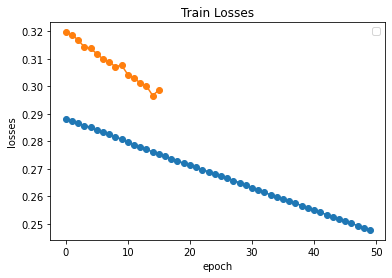

In [16]:
plt.plot(save_loss_train,'-o')
plt.plot(save_loss_test, '-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train'],['Test'])
plt.title('Train Losses')
 
plt.show()

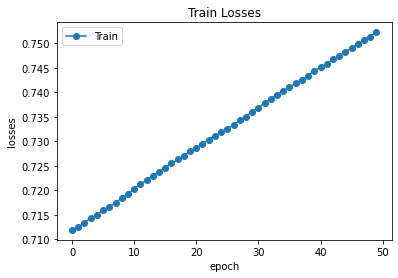

In [17]:
plt.plot(save_metric_train,'-o')

plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train'])
plt.title('Train Losses')
 
plt.show()